In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from numpy import inf
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.colorbar import ColorbarBase
from scipy import stats
from scipy.spatial import distance


In [2]:
def calc_kstest(d1,d2,confidence_level,alternative='two_sided'):
    if d1.ndim == 1:
        ks = stats.ks_2samp(d1, d2, alternative=alternative)
        return ks[0],ks[1]
    else:

        n_samples,n_vars = d1.shape
        threshold = 100 - confidence_level
        vars = ['Mean sea level pressure', 'U 850 hPa', 'V 850 hPa', 'Wind shear', 'Latitude', 'Longitude','Temperature','Relative humidity']
        for i in range(n_vars):
            ks = stats.ks_2samp(d1[:,i], d2[:,i], alternative=alternative)
            print(f'{vars[i]}')
            print('ks statistic = ',ks[0],'ks p value = ',ks[1])
            
            kw = stats.kruskal(d1[:,i], d2[:,i])
            print('kw statistic = ',kw[0],'kw p value = ',kw[1])

            mwu = stats.mannwhitneyu(d1[:,i], d2[:,i])
            print('mwu statistic = ',mwu[0],'mwu p value = ',mwu[1])
            print('')
    


In [3]:
disc_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_disc_pred-opt_modular_part2_raw.npy')
gen_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_modular_part2_raw.npy')
gen_weighted_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_weighted_pred-opt_modular_part2_raw.npy')
disc_weighted_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_weighted_disc_pred-opt_modular_part2_raw.npy')
real = np.load('/user/home/al18709/work/gan_predictions_20/validation_real-opt_modular_part2_raw.npy')
# patchloss_disc_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_disc_pred-opt_modular_part2_patchloss_raw.npy')
# # gen_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_modular_part2_patchloss_raw.npy')
patchloss_disc_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_disc_pred-opt_modular_part2_patchloss_raw_4.npy')
patchloss_gen_pred = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_modular_part2_patchloss_raw_4.npy')

inputs = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/valid_X.npy')
inputs_more = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/all_valid_X.npy')
training_inputs = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/train_X.npy')


In [4]:
# training_lons = training_inputs[:,5]
# training_mslp = training_inputs[:,0]
# mean_slp = np.mean(training_mslp)
# west = np.sum(training_lons < 0)
# east = np.sum(training_lons > 0)

# west_strong = np.sum((training_lons < 0) & (training_mslp<mean_slp))
# west_weak = np.sum((training_lons < 0) & (training_mslp>mean_slp))

# east_strong = np.sum((training_lons > 0) & (training_mslp<mean_slp))
# east_weak = np.sum((training_lons > 0) & (training_mslp>mean_slp))
# plt.bar(['East','West'],[east_weak,west_weak])
# plt.bar(['East','West'], [east_strong,west_strong], bottom=[east_weak,west_weak], color='b')
# plt.show()


In [5]:
# # sns.set_style("whitegrid")  # You can change the style to your preference
# sns.kdeplot(disc_pred[:,0,0], shade=True, color="#3E579C")
# sns.kdeplot(disc_weighted_pred[:,0,0], shade=True)
# # plt.title("Kernel Density Estimation (KDE) Plot")
# plt.xlabel("Critic output")
# plt.ylabel("Density")
# plt.show()

In [6]:
# define percentiles and limits

percentiles = np.arange(0,100,10)
pred_p = np.percentile(disc_pred[:,0,0], percentiles)
pred_pw = np.percentile(disc_weighted_pred[:,0,0], percentiles)
pred_pl = np.percentile(patchloss_disc_pred[:,0,0], percentiles)
min = np.min(disc_pred[:,0,0])
max = np.max(disc_pred[:,0,0])
minw = np.min(disc_weighted_pred[:,0,0])
maxw = np.max(disc_weighted_pred[:,0,0])
minpl = np.min(patchloss_disc_pred[:,0,0])
maxpl = np.max(patchloss_disc_pred[:,0,0])
limits = [0] * 10
limits[-1] = max
limits[0:-1] = pred_p
limitsw = [0] * 10
limitsw[-1] = maxw
limitsw[0:-1] = pred_pw
limitpl = [0] * 10
limitpl[-1] = maxpl
limitpl[0:-1] = pred_pl

In [7]:
def calc_percentiles(i,d_p,l):
    p_10 = i[(d_p[:,0,0] > l[0]) & (d_p[:,0,0] < l[1]),:]
    p_20 = i[(d_p[:,0,0] > l[1]) & (d_p[:,0,0] < l[2]),:]
    p_30 = i[(d_p[:,0,0] > l[2]) & (d_p[:,0,0] < l[3]),:]
    p_40 = i[(d_p[:,0,0] > l[3]) & (d_p[:,0,0] < l[4]),:]
    p_50 = i[(d_p[:,0,0] > l[4]) & (d_p[:,0,0] < l[5]),:]
    p_60 = i[(d_p[:,0,0] > l[5]) & (d_p[:,0,0] < l[6]),:]
    p_70 = i[(d_p[:,0,0] > l[6]) & (d_p[:,0,0] < l[7]),:]
    p_80 = i[(d_p[:,0,0] > l[7]) & (d_p[:,0,0] < l[8]),:]
    p_90 = i[(d_p[:,0,0] > l[8]) & (d_p[:,0,0] < l[9]),:]
    p_100 = i[(d_p[:,0,0] > l[9]) & (d_p[:,0,0] < l[10]),:]
    return p_10,p_20,p_30,p_40,p_50,p_60,p_70,p_80,p_90,p_100

In [8]:
print(inputs.shape)

(15930, 6)


In [9]:

def plot_kdes(p_10_,p_20,p_30,p_40,p_50,p_60,p_70,p_80,p_90,p_100_,inputs_,title,colour1,colour2,all_deciles=False,plot_inputs=True):

    sns.set_style("whitegrid")  # You can change the style to your preference
    height_ratios = [1,0.08,1]

    _,n_inputs = inputs_.shape
    inputs_2 = np.copy(inputs_)

    if n_inputs == 6:

        fig, axes = plt.subplots(3, 3, figsize=(16, 8),gridspec_kw={'height_ratios': height_ratios})
        titles = ['Mean sea level pressure (hPa)', 'U 850 hPa (ms$^{-1}$)', 'V 850 hPa (ms$^{-1}$)', 'Wind shear (ms$^{-1}$)', 'Latitude (Degrees North)', 'Longitude (Degrees East)']
        labels = ['a.','b.','c.','d.','e.','f.']
    else:
        fig, axes = plt.subplots(3, 4, figsize=(28, 12),gridspec_kw={'height_ratios': height_ratios})
        titles = ['Mean sea level pressure (hPa)', 'U 850 hPa (ms$^{-1}$)', 'V 850 hPa (ms$^{-1}$)', 'Wind shear (ms$^{-1}$)', 'Latitude (Degrees North)', 'Longitude (Degrees East)','Temperature 600 hPa (Celcius)','Relative humidity 600 hPa (%)']
        labels = ['a.','b.','c.','d.','e.','f.','g.','h.']
        p_10_[:,6] = p_10_[:,6] - 273.15
        p_100_[:,6] = p_100_[:,6] - 273.15
        inputs_2[:,6] = inputs_[:,6] - 273.15


    for i in range(n_inputs):
        row, col = divmod(i, int(n_inputs/2))
        # print(row,col)
        if row == 1:
            # axes[row,col].set_facecolor('white')
            # axes[row,col] = 'off'
            axes[row,col].set_axis_off()
            row = 2
        # print(axes[row,col])
        sns.kdeplot(p_10_[:,i], fill=True, color=colour1, ax=axes[row,col])
        # sns.kdeplot(p_20[:,i], fill=True, color="#98B5D9", ax=axes[row,col])
        # sns.kdeplot(p_30[:,i], fill=True, color="#89A0CF", ax=axes[row,col])
        # sns.kdeplot(p_40[:,i], fill=True, color="#799AC5", ax=axes[row,col])
        # sns.kdeplot(p_50[:,i], fill=True, color="#6A88BB", ax=axes[row,col])
        # sns.kdeplot(p_60[:,i], fill=True, color="#5B78B0", ax=axes[row,col])
        # sns.kdeplot(p_70[:,i], fill=True, color="#4C67A6", ax=axes[row,col])
        # sns.kdeplot(p_80[:,i], fill=True, color="#3E579C", ax=axes[row,col])
        # sns.kdeplot(p_90[:,i], fill=True, color="#2F4792", ax=axes[row,col])
        sns.kdeplot(p_100_[:,i], fill=True, color=colour2, ax=axes[row,col])
        if plot_inputs == True:
            sns.kdeplot(inputs_2[:,i],fill=False, color="Black", ax=axes[row,col])
        axes[row,col].text(-0.1, 1.05, labels[i], transform=axes[row,col].transAxes, size=24, weight='bold')
        # axes[row,col].set_title(titles[i])
        axes[row,col].set_xlabel(titles[i],size=22)
        axes[row,col].set_ylabel("")
        axes[row,col].tick_params(axis='both', which='major', labelsize=14)
        ks_stat,ks_pvalue = calc_kstest(p_10_[:,i],p_100_[:,i],95)
        axes[row,col].text(0.06, 0.93, f'K-S statistic: {ks_stat:.2f}', transform=axes[row,col].transAxes, size=14)
        axes[row,col].text(0.06, 0.88, f'p value: {ks_pvalue:.2f}', transform=axes[row,col].transAxes, size=14)
        
    if plot_inputs == True:
        axes[0,3].legend(['Bottom decile pl','Top decile pl','All deciles'],loc='upper right')
    else:
        axes[0,3].legend(['MWGAN top decile - bottom decile','Patchloss top decile - bottom decile'],loc='upper right')
    axes[0,0].set_ylabel('Density')
    axes[2,0].set_ylabel('Density')
    # plt.title("Kernel Density Estimation (KDE) Plot")
    # plt.xlabel("Values")
    # plt.ylabel("Density")
    # plt.show()
    plt.savefig(title,bbox_inches='tight',dpi=600)

In [10]:
print(limits)
print(limitpl)

[5.512174606323242, 9.066775226593018, 9.833500480651855, 10.403750991821289, 10.939079093933106, 11.45340633392334, 12.014235877990723, 12.644102191925048, 13.443285560607912, 14.693383026123048, 25.534744262695312]
[0.40691953897476196, 9.618859958648681, 12.458081817626953, 14.841539001464843, 17.213434219360355, 19.805794715881348, 22.70786323547363, 26.046479988098145, 30.74317970275879, 38.03474502563477, 102.86772155761719]


In [11]:
p_10,p_20,p_30,p_40,p_50,p_60,p_70,p_80,p_90,p_100 = calc_percentiles(inputs_more,disc_pred,limits)
# pw_10,pw_20,pw_30,pw_40,pw_50,pw_60,pw_70,pw_80,pw_90,pw_100 = calc_percentiles(inputs,disc_weighted_pred,limitsw)
pl_10,pl_20,pl_30,pl_40,pl_50,pl_60,pl_70,pl_80,pl_90,pl_100 = calc_percentiles(inputs_more,patchloss_disc_pred,limitpl)




In [12]:
# # sns.set_style("whitegrid")  # You can change the style to your preference
# kde = gaussian_kde(disc_pred[:,0,0])
# kdew = gaussian_kde(disc_weighted_pred[:,0,0])

# colours = ["#A8CCE3","#98B5D9","#89A0CF", "#799AC5", "#6A88BB", "#5B78B0","#4C67A6", "#3E579C","#2F4792","#204587","black"]
# print(kde.evaluate(limits[0]))
# x_kde, y_kde = sns.kdeplot(disc_pred[:,0,0]).get_lines()[0].get_data()
# # x_kdew, y_kdew = sns.kdeplot(disc_weighted_pred[:,0,0]).get_lines()[0].get_data()

# for i in range(10):
# 	if i in range(1,9):
# 		y = y_kde[(x_kde >= limits[1]) & (x_kde <= limits[9])]
# 		x = x_kde[(x_kde >= limits[1]) & (x_kde <= limits[9])]
# 		print(y)
# 		print(x)
# 		plt.fill_between(x,y, color=colours[2], alpha=0.2)
# 		continue
# 	[y1] = kde.evaluate(limits[i])
# 	[y2] = kde.evaluate(limits[i+1])
# 	y = y_kde[(x_kde >= limits[i]) & (x_kde <= limits[i+1])]
# 	x = x_kde[(x_kde >= limits[i]) & (x_kde <= limits[i+1])]
# 	print(y)
# 	print(x)
# 	plt.fill_between(x,y, color=colours[i], alpha=0.6)
# 	line1_x = limits[i]
# 	line2_x = limits[i+1]
# 	print(y1,y2)
# 	y2 = np.maximum(y1,y2)
# 	y1 = np.minimum(y1,y2)
# 	# plt.fill_betweenx([0,y2], line1_x, x2=line2_x, color=colours[i], alpha=0.6)
# 	# plt.plot([limits[i],limits[i]],[0,y1],color=colours[i],fill=True)


# # [y_max] = kde.evaluate(np.mean(disc_pred[:,0,0]))


# # plt.fill_betweenx(y_kde, x_kde, color='orange', alpha=0.4, label='Opposite Area')
# # 
# sns.kdeplot(disc_pred[:,0,0], shade=False, color="#3E579C")
# # plt.title("Kernel Density Estimation (KDE) Plot")
# plt.xlabel("Critic output")
# plt.ylabel("Density")
# plt.show()

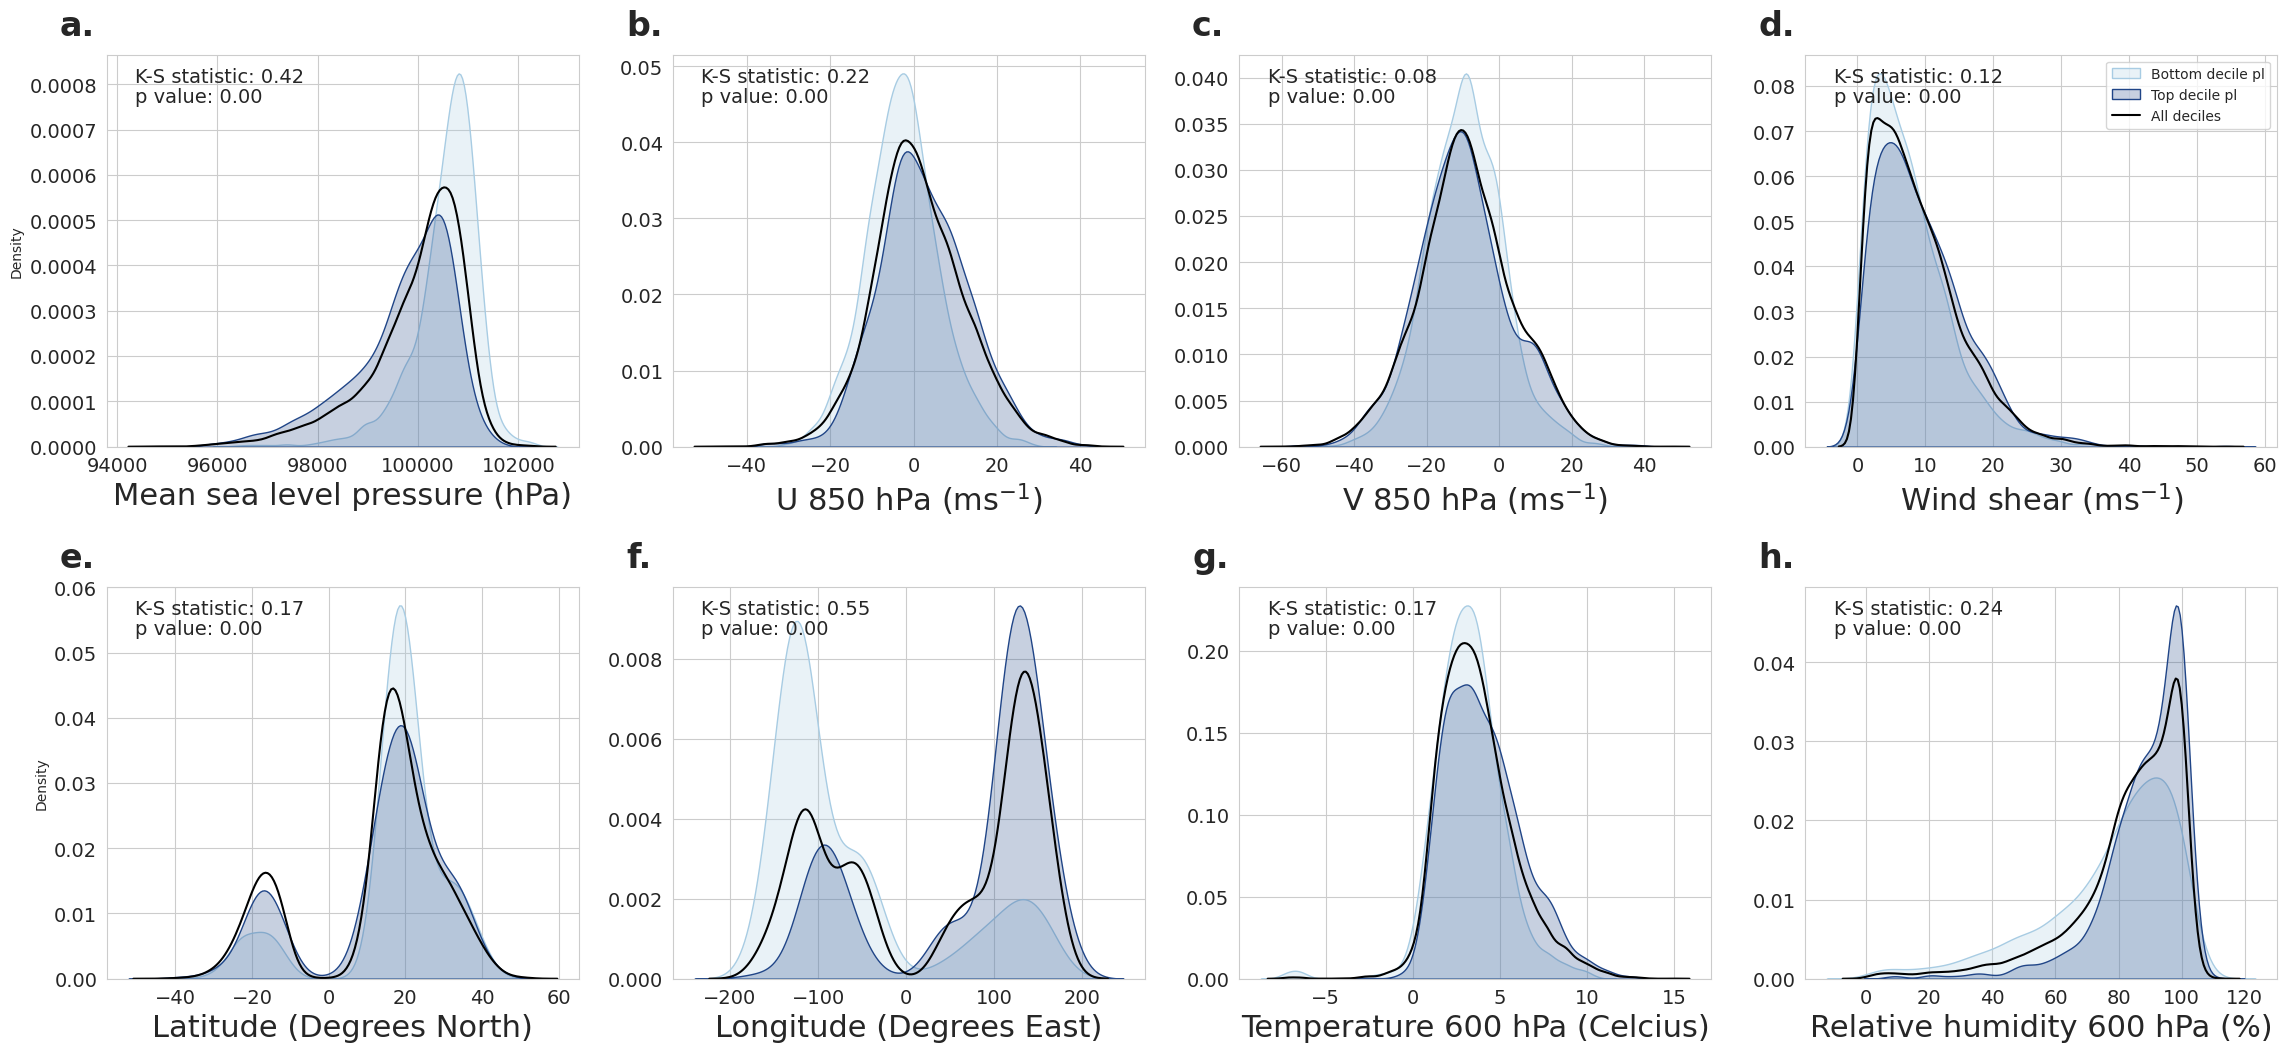

In [13]:
plot_kdes(p_10,p_20,p_30,p_40,p_50,p_60,p_70,p_80,p_90,p_100,inputs_more,'figure_9a_weighted_inputs_4.png',"#A8CCE3","#204587",all_deciles=False)

In [14]:
# plot_kdes(pl_10,pl_20,pl_30,pl_40,pl_50,pl_60,pl_70,pl_80,pl_90,pl_100,inputs,'figure_9a_patchloss.png',"green","pink",all_deciles=False)

In [15]:
p_10,p_20,p_30,p_40,p_50,p_60,p_70,p_80,p_90,p_100 = calc_percentiles(inputs_more,disc_pred,limits)
pw_10,pw_20,pw_30,pw_40,pw_50,pw_60,pw_70,pw_80,pw_90,pw_100 = calc_percentiles(inputs_more,disc_weighted_pred,limitsw)
pl_10,pl_20,pl_30,pl_40,pl_50,pl_60,pl_70,pl_80,pl_90,pl_100 = calc_percentiles(inputs_more,patchloss_disc_pred,limitpl)

In [16]:
def calc_distance(d1,d2):
    n_samples,n_vars = d1.shape
    vars = ['Mean sea level pressure', 'U 850 hPa', 'V 850 hPa', 'Wind shear', 'Latitude', 'Longitude','Temperature','Relative humidity']
    for i in range(n_vars):
        dist = distance.braycurtis(d1[:,i], d2[:,i])
        print(vars[i])
        print(dist)


In [17]:
# plot_kdes(p_10,p_20,p_30,p_40,p_50,p_60,p_70,p_80,p_90,p_100,inputs_more,'figure_9a_inputs_5.png',"#A8CCE3","#204587",all_deciles=False)
# calc_kstest(p_10,p_100,95)
# calc_distance(p_10,p_100)
# The KS test statistic is defined as the maximum value of the difference between A and B’s cumulative distribution functions (CDF).

Mean sea level pressure
ks statistic =  0.1934673366834171 ks p value =  1.8479642542918484e-26
kw statistic =  143.16010599670022 kw p value =  5.422813054054504e-33
mwu statistic =  1577558.0 mwu p value =  5.424072649161258e-33

U 850 hPa
ks statistic =  0.14824120603015076 ks p value =  1.1374991703327159e-15
kw statistic =  61.782077042530844 kw p value =  3.836505369292033e-15
mwu statistic =  1063369.0 mwu p value =  3.8370958806350195e-15

V 850 hPa
ks statistic =  0.023241206030150754 ks p value =  0.7832778051378081
kw statistic =  0.1667476104835043 kw p value =  0.6830186342945676
mwu statistic =  1256641.0 mwu p value =  0.6830327855783052

Wind shear
ks statistic =  0.07537688442211055 ks p value =  0.00023455616848589938
kw statistic =  16.88069832479603 kw p value =  3.980429506623265e-05
mwu statistic =  1160670.0 mwu p value =  3.980761724533544e-05

Latitude
ks statistic =  0.10301507537688442 ks p value =  8.977130553640978e-08
kw statistic =  2.0495542381680845 kw 

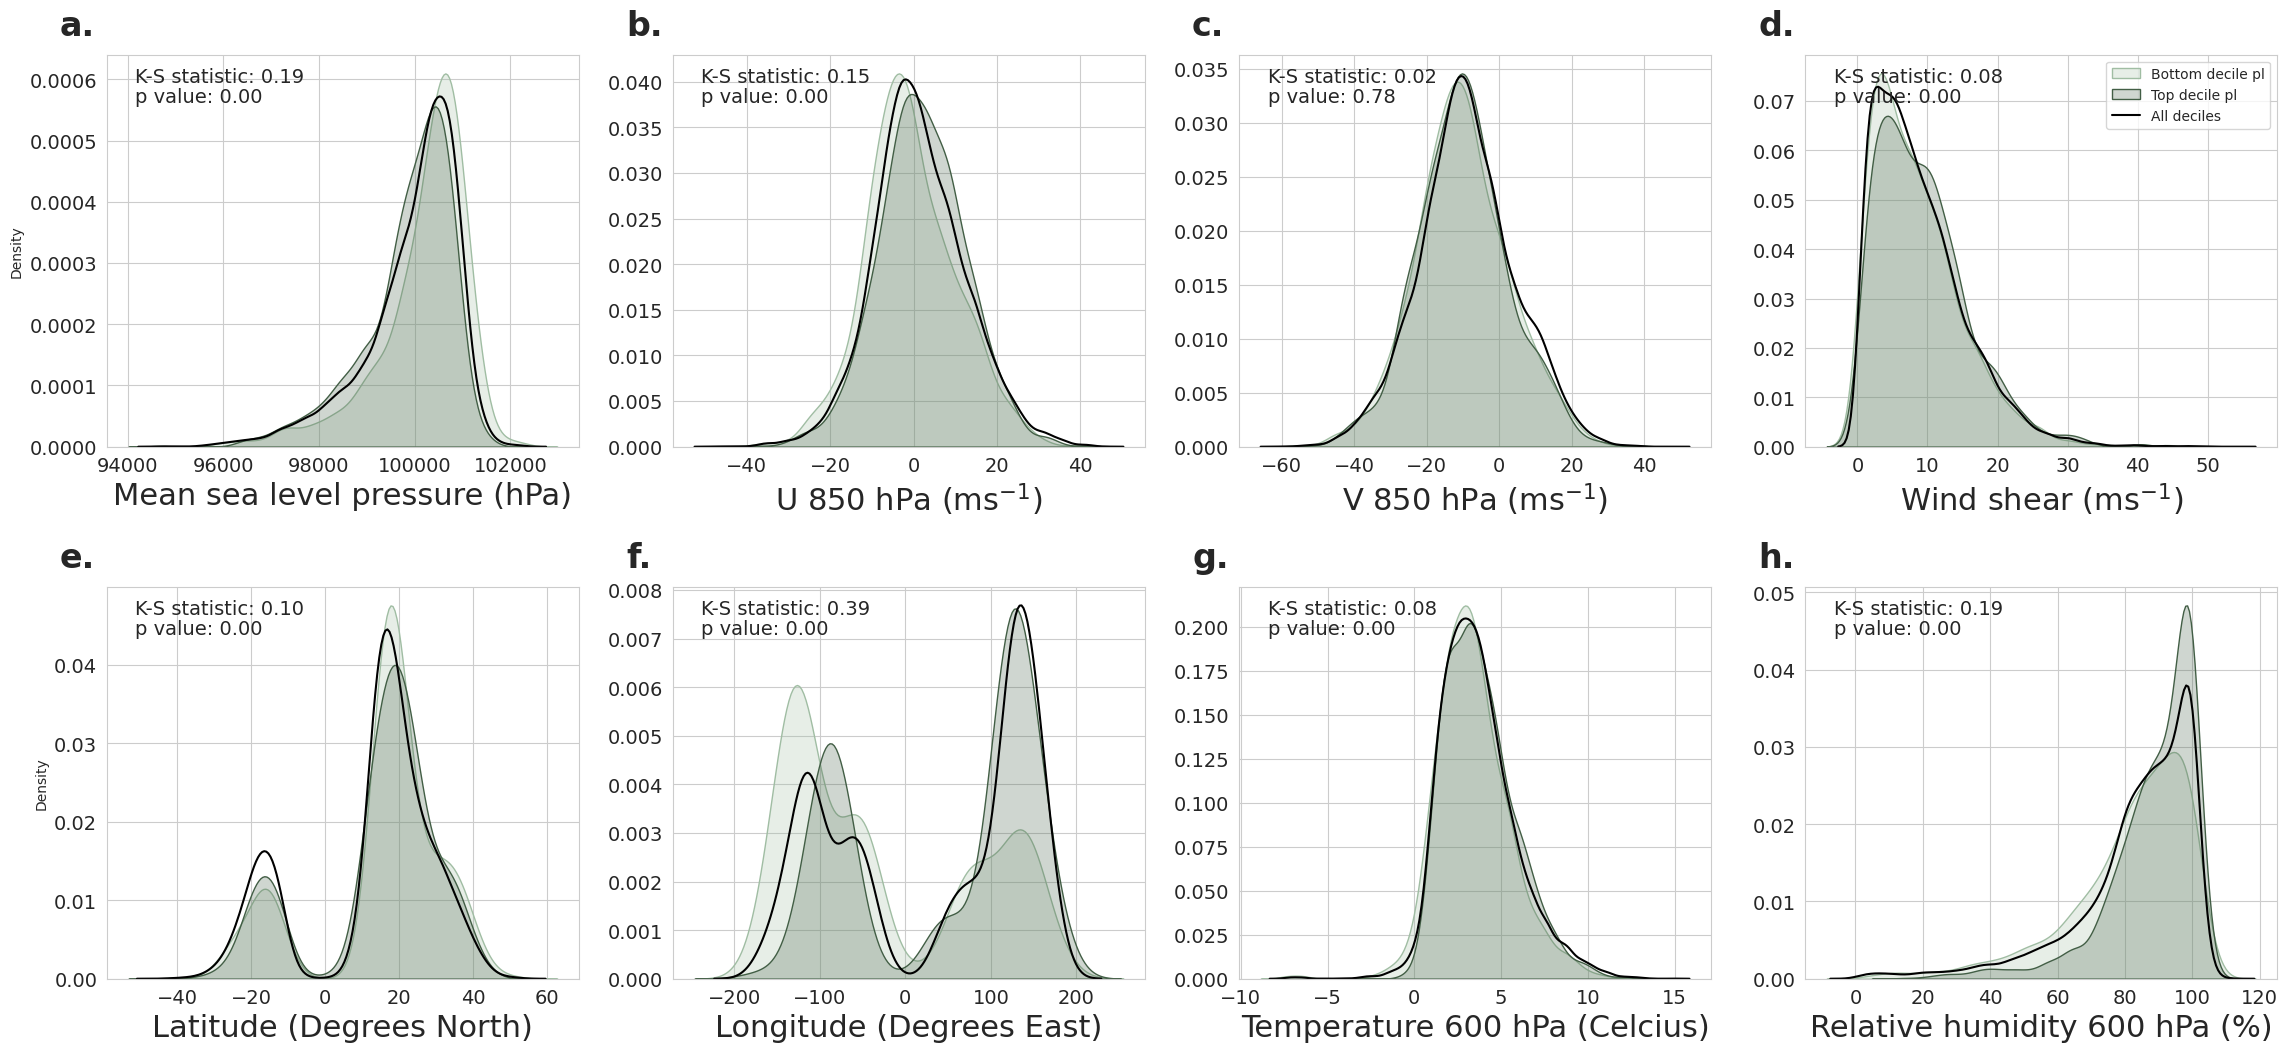

In [18]:
plot_kdes(pl_10,pl_20,pl_30,pl_40,pl_50,pl_60,pl_70,pl_80,pl_90,pl_100,inputs_more,'figure_9a_patchloss_4b.png',"#a0bda3","#425e45",all_deciles=False)
calc_kstest(pl_10,pl_100,95)
# calc_distance(pl_10,pl_100)

Mean sea level pressure
ks statistic =  0.028266331658291458 ks p value =  0.28033925254922176
kw statistic =  0.004827199613498439 kw p value =  0.9446091029472635
mwu statistic =  1269034.0 mwu p value =  0.9446244475277986

U 850 hPa
ks statistic =  0.04962311557788945 ks p value =  0.019829111832762123
kw statistic =  4.0633268835257255 kw p value =  0.043824078919347954
mwu statistic =  1319513.5 mwu p value =  0.04382609575785552

V 850 hPa
ks statistic =  0.08103015075376885 ks p value =  2.8629718671451922e-05
kw statistic =  14.025097012902934 kw p value =  0.00018038686754519908
mwu statistic =  1364363.5 mwu p value =  0.00018040071938516805

Wind shear
ks statistic =  0.014447236180904523 ks p value =  0.7173484005854847
kw statistic =  0.025325606032791177 kw p value =  0.8735584098841581
mwu statistic =  1263104.5 mwu p value =  0.8735735980078936

Latitude
ks statistic =  0.03957286432160804 ks p value =  0.08266507247077405
kw statistic =  0.2128371290999972 kw p value 

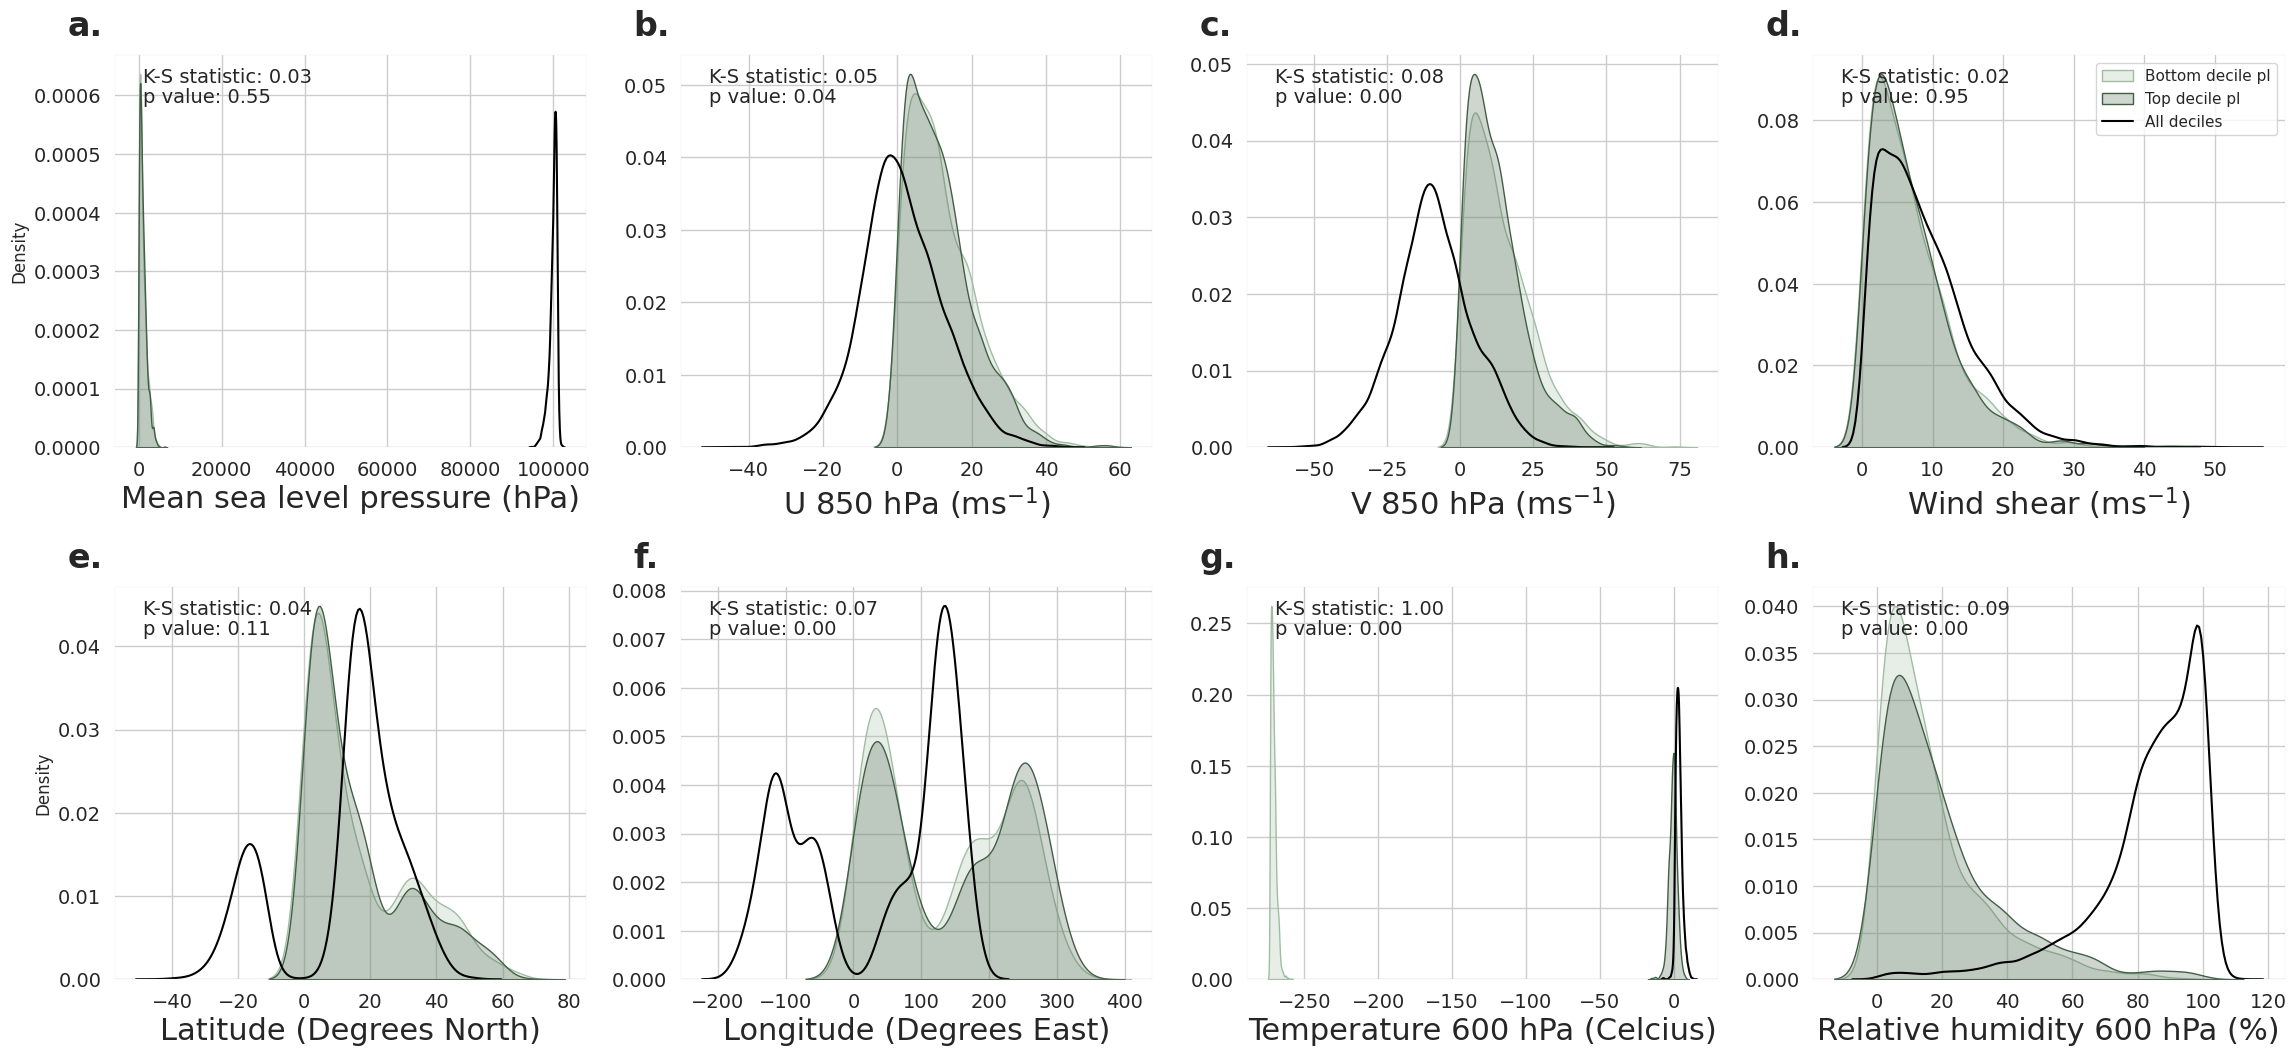

In [49]:
plot_kdes(abs(pl_10-pl_100),pl_20,pl_30,pl_40,pl_50,pl_60,pl_70,pl_80,pl_90,abs(p_10-pl_100),inputs_more,'figure_9a_patchloss_4b.png',"#a0bda3","#425e45",all_deciles=False)
calc_kstest(abs(pl_10-pl_100),abs(p_10-pl_100),95,alternative='less')

In [19]:
# sns.set_style("whitegrid")  # You can change the style to your preference
# height_ratios = [1,0.08,1]
# fig, axes = plt.subplots(3, 3, figsize=(16, 8),gridspec_kw={'height_ratios': height_ratios})
# titles = ['Mean sea level pressure (hPa)', 'U 850 hPa (ms$^{-1}$)', 'V 850 hPa (ms$^{-1}$)', 'Wind shear (ms$^{-1}$)', 'Latitude (Degrees North)', 'Longitude (Degrees East)']
# labels = ['a.','b.','c.','d.','e.','f.']

# for i in range(6):
#     row, col = divmod(i, 3)
    
#     if row == 1:
#         axes[row,col].set_axis_off()
#         row = 2
       
#     sns.kdeplot(inputs[:,i],fill=False, color="Black", ax=axes[row,col])
#     sns.kdeplot(pl_10[:,i], fill=True, color="yellow", ax=axes[row,col])
#     sns.kdeplot(pl_100[:,i], fill=True, color="green", ax=axes[row,col])
    
#     axes[row,col].text(-0.1, 1.05, labels[i], transform=axes[row,col].transAxes, size=18, weight='bold')
#     # axes[row,col].set_title(titles[i])
#     axes[row,col].set_xlabel(titles[i])
#     axes[row,col].set_ylabel("")
    
# axes[0,0].set_ylabel('Density')
# axes[2,0].set_ylabel('Density')
# # axes[0,0].legend(['Bottom decile','Top decile','All deciles','Bottom decile pl','Top decile pl',],loc='upper left')
# axes[0,0].legend(['All deciles','Bottom decile pl','Top decile pl',],loc='upper left')
# # plt.title("Kernel Density Estimation (KDE) Plot")
# # plt.xlabel("Values")
# # plt.ylabel("Density")
# # plt.show()
# plt.savefig('figure_9a_inputs_5.png',bbox_inches='tight',dpi=600)

In [20]:
# sns.set_style("whitegrid")  # You can change the style to your preference
# height_ratios = [1,0.08,1]
# fig, axes = plt.subplots(3, 3, figsize=(16, 8),gridspec_kw={'height_ratios': height_ratios})
# titles = ['Mean sea level pressure (hPa)', 'U 850 hPa (ms$^{-1}$)', 'V 850 hPa (ms$^{-1}$)', 'Wind shear (ms$^{-1}$)', 'Latitude (Degrees North)', 'Longitude (Degrees East)']
# labels = ['a.','b.','c.','d.','e.','f.']

# for i in range(6):
#     row, col = divmod(i, 3)
    
#     if row == 1:
#         # axes[row,col].set_facecolor('white')
#         # axes[row,col] = 'off'
#         axes[row,col].set_axis_off()
#         row = 2
#     sns.kdeplot(p_10[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
#     # sns.kdeplot(p_20[:,i], fill=True, color="#98B5D9", ax=axes[row,col])
#     # sns.kdeplot(p_30[:,i], fill=True, color="#89A0CF", ax=axes[row,col])
#     # sns.kdeplot(p_40[:,i], fill=True, color="#799AC5", ax=axes[row,col])
#     # sns.kdeplot(p_50[:,i], fill=True, color="#6A88BB", ax=axes[row,col])
#     # sns.kdeplot(p_60[:,i], fill=True, color="#5B78B0", ax=axes[row,col])
#     # sns.kdeplot(p_70[:,i], fill=True, color="#4C67A6", ax=axes[row,col])
#     # sns.kdeplot(p_80[:,i], fill=True, color="#3E579C", ax=axes[row,col])
#     # sns.kdeplot(p_90[:,i], fill=True, color="#2F4792", ax=axes[row,col])
#     sns.kdeplot(p_100[:,i], fill=True, color="#204587", ax=axes[row,col])
#     sns.kdeplot(inputs[:,i],fill=False, color="Black", ax=axes[row,col])
#     axes[row,col].text(-0.1, 1.05, labels[i], transform=axes[row,col].transAxes, size=18, weight='bold')
#     # axes[row,col].set_title(titles[i])
#     axes[row,col].set_xlabel(titles[i])
#     axes[row,col].set_ylabel("")
    
# axes[0,0].set_ylabel('Density')
# axes[2,0].set_ylabel('Density')
# # plt.title("Kernel Density Estimation (KDE) Plot")
# # plt.xlabel("Values")
# # plt.ylabel("Density")
# # plt.show()
# plt.savefig('figure_9a_weighted_inputs_4.png',bbox_inches='tight',dpi=600)

In [21]:
pred_10 = gen_pred[(disc_pred[:,0,0] > limits[0]) & (disc_pred[:,0,0] < limits[1]),:,:]
pred_100 = gen_pred[(disc_pred[:,0,0] > limits[9]) & (disc_pred[:,0,0] < limits[10]),:,:]

pred_10_pl = patchloss_gen_pred[(patchloss_disc_pred[:,0,0] > limitpl[0]) & (patchloss_disc_pred[:,0,0] < limitpl[1]),:,:]
pred_100_pl = patchloss_gen_pred[(patchloss_disc_pred[:,0,0] > limitpl[9]) & (patchloss_disc_pred[:,0,0] < limitpl[10]),:,:]

print(pred_10_pl.shape)
print(pred_100_pl.shape)

(1592, 100, 100, 20)
(1592, 100, 100, 20)


In [22]:
sns.set_style("white")
height_ratios = [1,0.01,1]
n = 3
m = 6
fig, axes = plt.subplots(n, m, figsize=(2*m + 0.5, 2*n), sharey=True,gridspec_kw={'height_ratios': height_ratios})


pal = sns.cubehelix_palette(10, rot=-.25, light=.7,as_cmap=True)

for i in range(m):
	for j in range(n):
		if j == 1:
			axes[j,i].set_axis_off()
			continue
		axes[j,i].set(xticklabels=[])
		axes[j,i].set(yticklabels=[])
		axes[j,i].spines['right'].set_color('#A9A9A9')  # Right spine color
		axes[j,i].spines['right'].set_linewidth(1) 
		axes[j,i].spines['left'].set_color('#A9A9A9')  # left spine color
		axes[j,i].spines['left'].set_linewidth(1)
		axes[j,i].spines['top'].set_color('#A9A9A9')  # top spine color
		axes[j,i].spines['top'].set_linewidth(1) 
		axes[j,i].spines['bottom'].set_color('#A9A9A9')  # bottom spine color
		axes[j,i].spines['bottom'].set_linewidth(1) 

		# axes[j,0].spines['bottom'].set_visible(False)
		# axes[j,0].spines['top'].set_visible(False)
		# axes[j,0].spines['left'].set_visible(False)
		# axes[j,0].spines['right'].set_visible(False)
		# axes[j,-1].spines['bottom'].set_visible(False)
		# axes[j,-1].spines['top'].set_visible(False)
		# axes[j,-1].spines['left'].set_visible(False)
		# axes[j,-1].spines['right'].set_visible(False)

# define cmap
precip_cmap,precip_norm = make_cmap()
norm = precip_norm

axes[0,0].text(-0.1, 1.05, 'a.', transform=axes[0,0].transAxes, size=16, weight='bold')
axes[2,0].text(-0.1, 1.05, 'b.', transform=axes[2,0].transAxes, size=16, weight='bold')

storms = np.random.randint(0,1000,6)
print(storms)
	
im = axes[0,0].imshow(pred_10[storms[0],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,0].invert_yaxis()
axes[0,1].imshow(pred_10[storms[1],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,1].invert_yaxis()
axes[0,2].imshow(pred_10[storms[2],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,2].invert_yaxis()
axes[0,3].imshow(pred_10[storms[3],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,3].invert_yaxis()
axes[0,4].imshow(pred_10[storms[4],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,4].invert_yaxis()
axes[0,5].imshow(pred_10[storms[5],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,5].invert_yaxis()

axes[2,0].imshow(pred_100[storms[0],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,0].invert_yaxis()
axes[2,1].imshow(pred_100[storms[1],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,1].invert_yaxis()
axes[2,2].imshow(pred_100[storms[2],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,2].invert_yaxis()
axes[2,3].imshow(pred_100[storms[3],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,3].invert_yaxis()
axes[2,4].imshow(pred_100[storms[4],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,4].invert_yaxis()
axes[2,5].imshow(pred_100[storms[5],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,5].invert_yaxis()





fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
# cbar_ax = fig.add_axes([1, 0.031, 0.03, 0.936])
cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
# cbar_ax = fig.add_axes([0, -0.1, 1, 0.02])
levels=[0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.01,ticks=levels)
cb.ax.tick_params(labelsize=12)
cb.set_label('mm / 3hr', fontsize=16)
fig.tight_layout()

plt.savefig('figure_9b_examples_4.png',bbox_inches='tight',dpi=600)
plt.clf()


[223 423   9  71 949 681]


/tmp/ipykernel_253095/2673552016.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<Figure size 1250x600 with 0 Axes>

[272  97 544 227 434 219]


/tmp/ipykernel_253095/2398195366.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


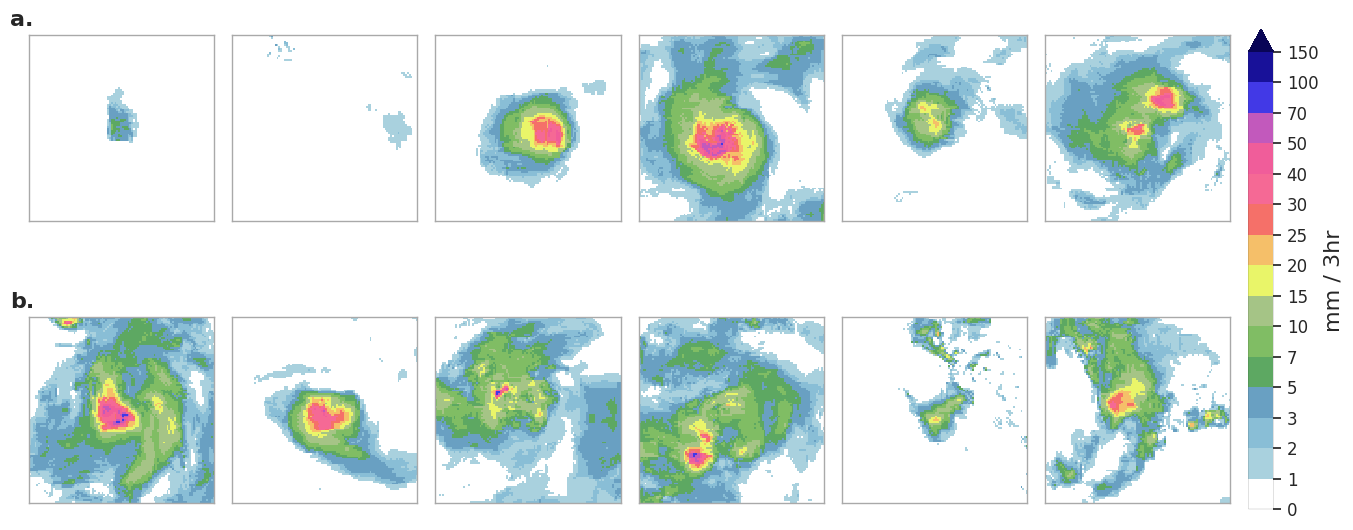

In [54]:
sns.set_style("white")
height_ratios = [1,0.01,1]
n = 3
m = 6
fig, axes = plt.subplots(n, m, figsize=(2*m + 0.5, 2*n), sharey=True,gridspec_kw={'height_ratios': height_ratios})


pal = sns.cubehelix_palette(10, rot=-.25, light=.7,as_cmap=True)

for i in range(m):
	for j in range(n):
		if j == 1:
			axes[j,i].set_axis_off()
			continue
		axes[j,i].set(xticklabels=[])
		axes[j,i].set(yticklabels=[])
		axes[j,i].spines['right'].set_color('#A9A9A9')  # Right spine color
		axes[j,i].spines['right'].set_linewidth(1) 
		axes[j,i].spines['left'].set_color('#A9A9A9')  # left spine color
		axes[j,i].spines['left'].set_linewidth(1)
		axes[j,i].spines['top'].set_color('#A9A9A9')  # top spine color
		axes[j,i].spines['top'].set_linewidth(1) 
		axes[j,i].spines['bottom'].set_color('#A9A9A9')  # bottom spine color
		axes[j,i].spines['bottom'].set_linewidth(1) 

		# axes[j,0].spines['bottom'].set_visible(False)
		# axes[j,0].spines['top'].set_visible(False)
		# axes[j,0].spines['left'].set_visible(False)
		# axes[j,0].spines['right'].set_visible(False)
		# axes[j,-1].spines['bottom'].set_visible(False)
		# axes[j,-1].spines['top'].set_visible(False)
		# axes[j,-1].spines['left'].set_visible(False)
		# axes[j,-1].spines['right'].set_visible(False)

# define cmap
precip_cmap,precip_norm = make_cmap()
norm = precip_norm

axes[0,0].text(-0.1, 1.05, 'a.', transform=axes[0,0].transAxes, size=16, weight='bold')
axes[2,0].text(-0.1, 1.05, 'b.', transform=axes[2,0].transAxes, size=16, weight='bold')

storms = np.random.randint(0,1000,6)
print(storms)
	
im = axes[0,0].imshow(pred_10_pl[storms[0],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,0].invert_yaxis()
axes[0,1].imshow(pred_10_pl[storms[1],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,1].invert_yaxis()
axes[0,2].imshow(pred_10_pl[storms[2],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,2].invert_yaxis()
axes[0,3].imshow(pred_10_pl[storms[3],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,3].invert_yaxis()
axes[0,4].imshow(pred_10_pl[storms[4],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,4].invert_yaxis()
axes[0,5].imshow(pred_10_pl[storms[5],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,5].invert_yaxis()

axes[2,0].imshow(pred_100_pl[storms[0],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,0].invert_yaxis()
axes[2,1].imshow(pred_100_pl[storms[1],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,1].invert_yaxis()
axes[2,2].imshow(pred_100_pl[storms[2],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,2].invert_yaxis()
axes[2,3].imshow(pred_100_pl[storms[3],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,3].invert_yaxis()
axes[2,4].imshow(pred_100_pl[storms[4],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,4].invert_yaxis()
axes[2,5].imshow(pred_100_pl[storms[5],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[2,5].invert_yaxis()





fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
# cbar_ax = fig.add_axes([1, 0.031, 0.03, 0.936])
cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
# cbar_ax = fig.add_axes([0, -0.1, 1, 0.02])
levels=[0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.01,ticks=levels)
cb.ax.tick_params(labelsize=12)
cb.set_label('mm / 3hr', fontsize=16)
fig.tight_layout()

plt.savefig('figure_9b_examples_corrected_Score.png',bbox_inches='tight',dpi=600)


In [24]:
print(np.mean(p_10))
print(np.mean(p_100))
print(np.mean(pl_10))
print(np.mean(pl_100))

print(np.sum(p_10))
print(np.sum(p_100))
print(np.sum(pl_10))
print(np.sum(pl_100))

print(np.sum(p_10>0))
print(np.sum(p_100>0))
print(np.sum(pl_10>0))
print(np.sum(pl_100>0))

print(np.sum(p_10>1))
print(np.sum(p_100>1))
print(np.sum(pl_10>1))
print(np.sum(pl_100>1))

12607.150289376308
12518.496755843351
12530.827130281188
12501.462799744868
160564666.08549666
159435574.6824209
159592614.33126122
159218630.21755064
8926
10075
9222
9886
8735
9945
8939
9687


5.512174606323242 25.534744262695312


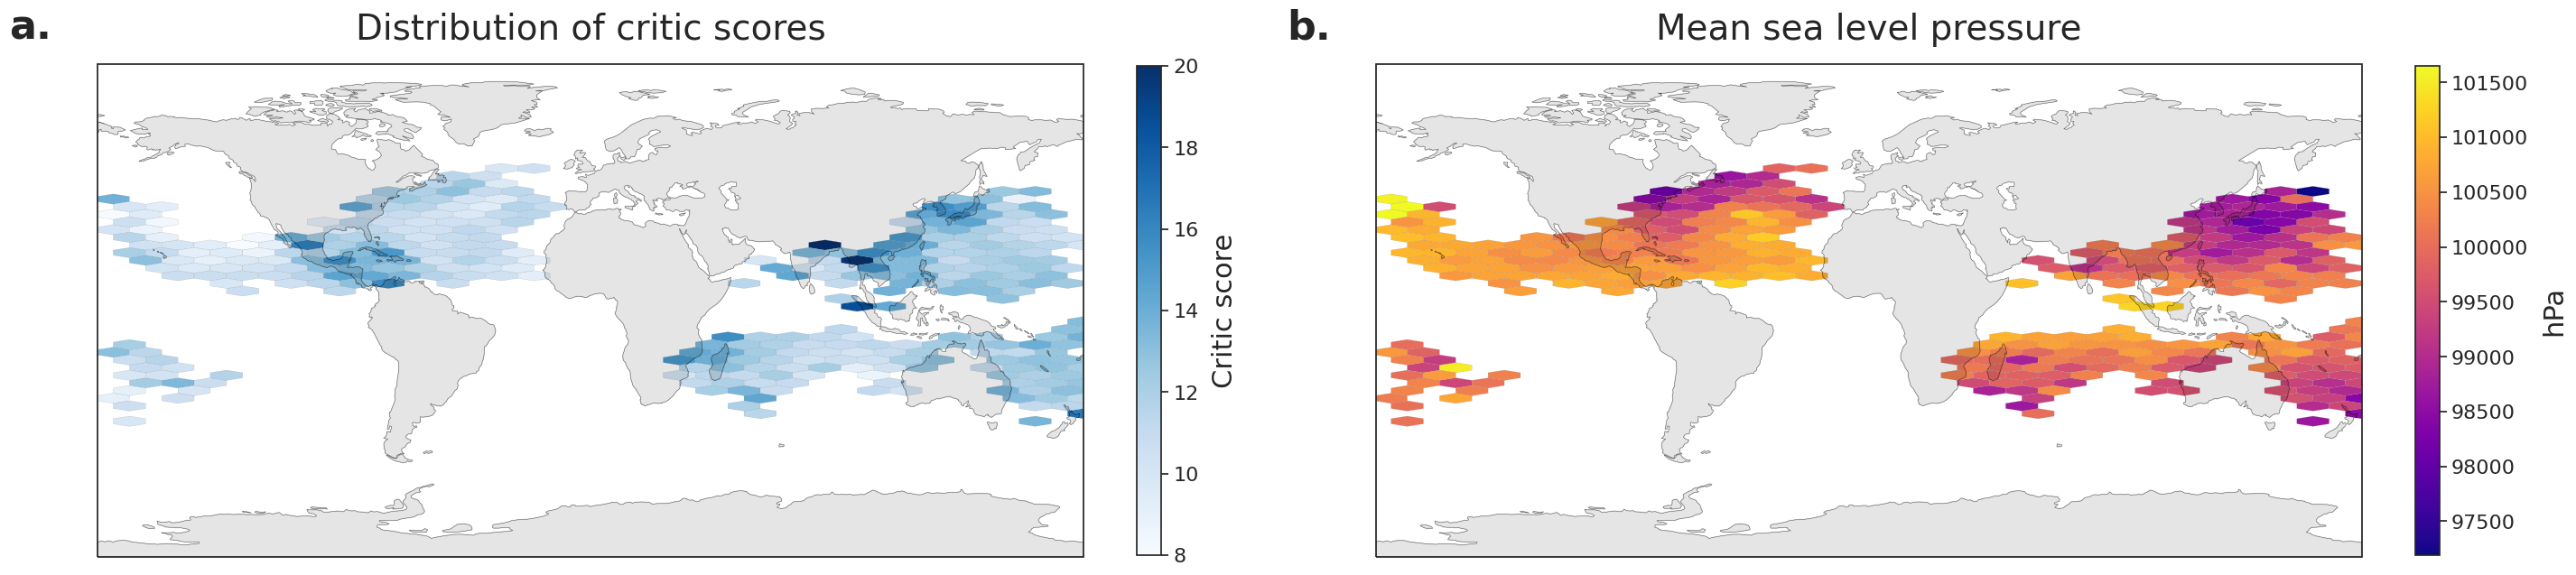

In [25]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=-2
vmax=2


fig, axes = plt.subplots(1,4,figsize=(35, 20),subplot_kw={'projection': ccrs.PlateCarree()},gridspec_kw={'width_ratios': [1, 0.001,1,0.001]})

# ax.set_xlim([-180, 180])
# ax.set_ylim([-90, 90])

# first panel
# axes[0].scatter(p_10[:,5],p_10[:,4], color="#A8CCE3",s=4,transform=ccrs.PlateCarree())
# axes[0].scatter(p_20[:,5],p_20[:,4], color="#98B5D9",s=4,transform=ccrs.PlateCarree())
# axes[0].scatter(p_30[:,5],p_30[:,4], color="#89A0CF",s=4,transform=ccrs.PlateCarree())
# axes[0].scatter(p_40[:,5],p_40[:,4], color="#799AC5",s=4,transform=ccrs.PlateCarree())
# axes[0].scatter(p_50[:,5],p_50[:,4], color="#6A88BB",s=4,transform=ccrs.PlateCarree())
# axes[0].scatter(p_60[:,5],p_60[:,4], color="#5B78B0",s=4,transform=ccrs.PlateCarree())
# axes[0].scatter(p_70[:,5],p_70[:,4], color="#4C67A6",s=4,transform=ccrs.PlateCarree())
# axes[0].scatter(p_80[:,5],p_80[:,4], color="#3E579C",s=4,transform=ccrs.PlateCarree())
# axes[0].scatter(p_90[:,5],p_90[:,4], color="#2F4792",s=4,transform=ccrs.PlateCarree())
# axes[0].scatter(p_100[:,5],p_100[:,4], color="#204587",s=4,transform=ccrs.PlateCarree())

# axes[0].add_feature(cfeature.COASTLINE,linewidth=0.2)
# axes[0].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)

# axes[0].tick_params(axis='x', labelsize=20)
# axes[0].tick_params(axis='y', labelsize=20)
# axes[0].set_title('Storm distribution',fontsize=28,pad=20)

x = inputs_more[:,5]
y = inputs_more[:,4]
z = disc_pred[:,0,0]
print(np.min(z),np.max(z))
m = axes[0].hexbin(x,y, C=z, gridsize=30, cmap='Blues', mincnt=1, edgecolor='gray',vmin=8,vmax=20, reduce_C_function=np.mean,linewidth=0.1, transform=ccrs.PlateCarree())
# m = axes[0].hexbin(x,y, C=z, gridsize=30, cmap='Blues', mincnt=1, edgecolor='gray',vmin=2,vmax=22, reduce_C_function=np.max,linewidth=0.1, transform=ccrs.PlateCarree())
axes[0].add_feature(cfeature.COASTLINE,linewidth=0.2)
axes[0].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)

axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[0].set_title('Distribution of critic scores',fontsize=28,pad=20)
axes[1].set_visible(False)
# plt.colorbar(m,ax=axes[1],fraction = 0.25,pad=-0.5,label = 'Critic score')
cb1 = plt.colorbar(m,ax=axes[0],fraction = 0.023,pad=0.05,label = 'Critic score')
cb1.set_label(label = 'Critic score',size=22,labelpad=10)
cb1.ax.tick_params(labelsize=16) 

# second panel
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
vmin=-2
vmax=2
width_ratios = [1,0.1]

x = inputs_more[:,5]
y = inputs_more[:,4]
z = inputs_more[:,0]
m2 = axes[2].hexbin(x,y, C=z, gridsize=30, cmap='plasma', mincnt=1, edgecolor='gray', reduce_C_function=np.mean,linewidth=0.1, transform=ccrs.PlateCarree())
axes[2].add_feature(cfeature.COASTLINE,linewidth=0.2)
axes[2].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)

axes[2].tick_params(axis='x', labelsize=20)
axes[2].tick_params(axis='y', labelsize=20)
axes[2].set_title('Mean sea level pressure',fontsize=28,pad=20)
axes[3].set_visible(False)

cb2 = plt.colorbar(m2,ax=axes[2],fraction = 0.023,pad=0.05,label='hPa')
cb2.set_label(label='hPa',size=22,labelpad=10)
cb2.ax.tick_params(labelsize=16) 




# plt.savefig('figure_9d_mslp_distribution_4.png')
axes[0].set_global()
axes[2].set_global()

# axes[0].outline_patch.se t_linewidth(0.1)
# axes[1].patch.set_linewidth(0.1)

axes[0].text(-0.09, 1.05, 'a.', transform=axes[0].transAxes, size=32, weight='bold')
axes[2].text(-0.09, 1.05, 'b.', transform=axes[2].transAxes, size=32, weight='bold')


# 

plt.tight_layout

plt.savefig('figure_9c_storm_distribution_4.png',bbox_inches='tight')

5.512174606323242 25.534744262695312


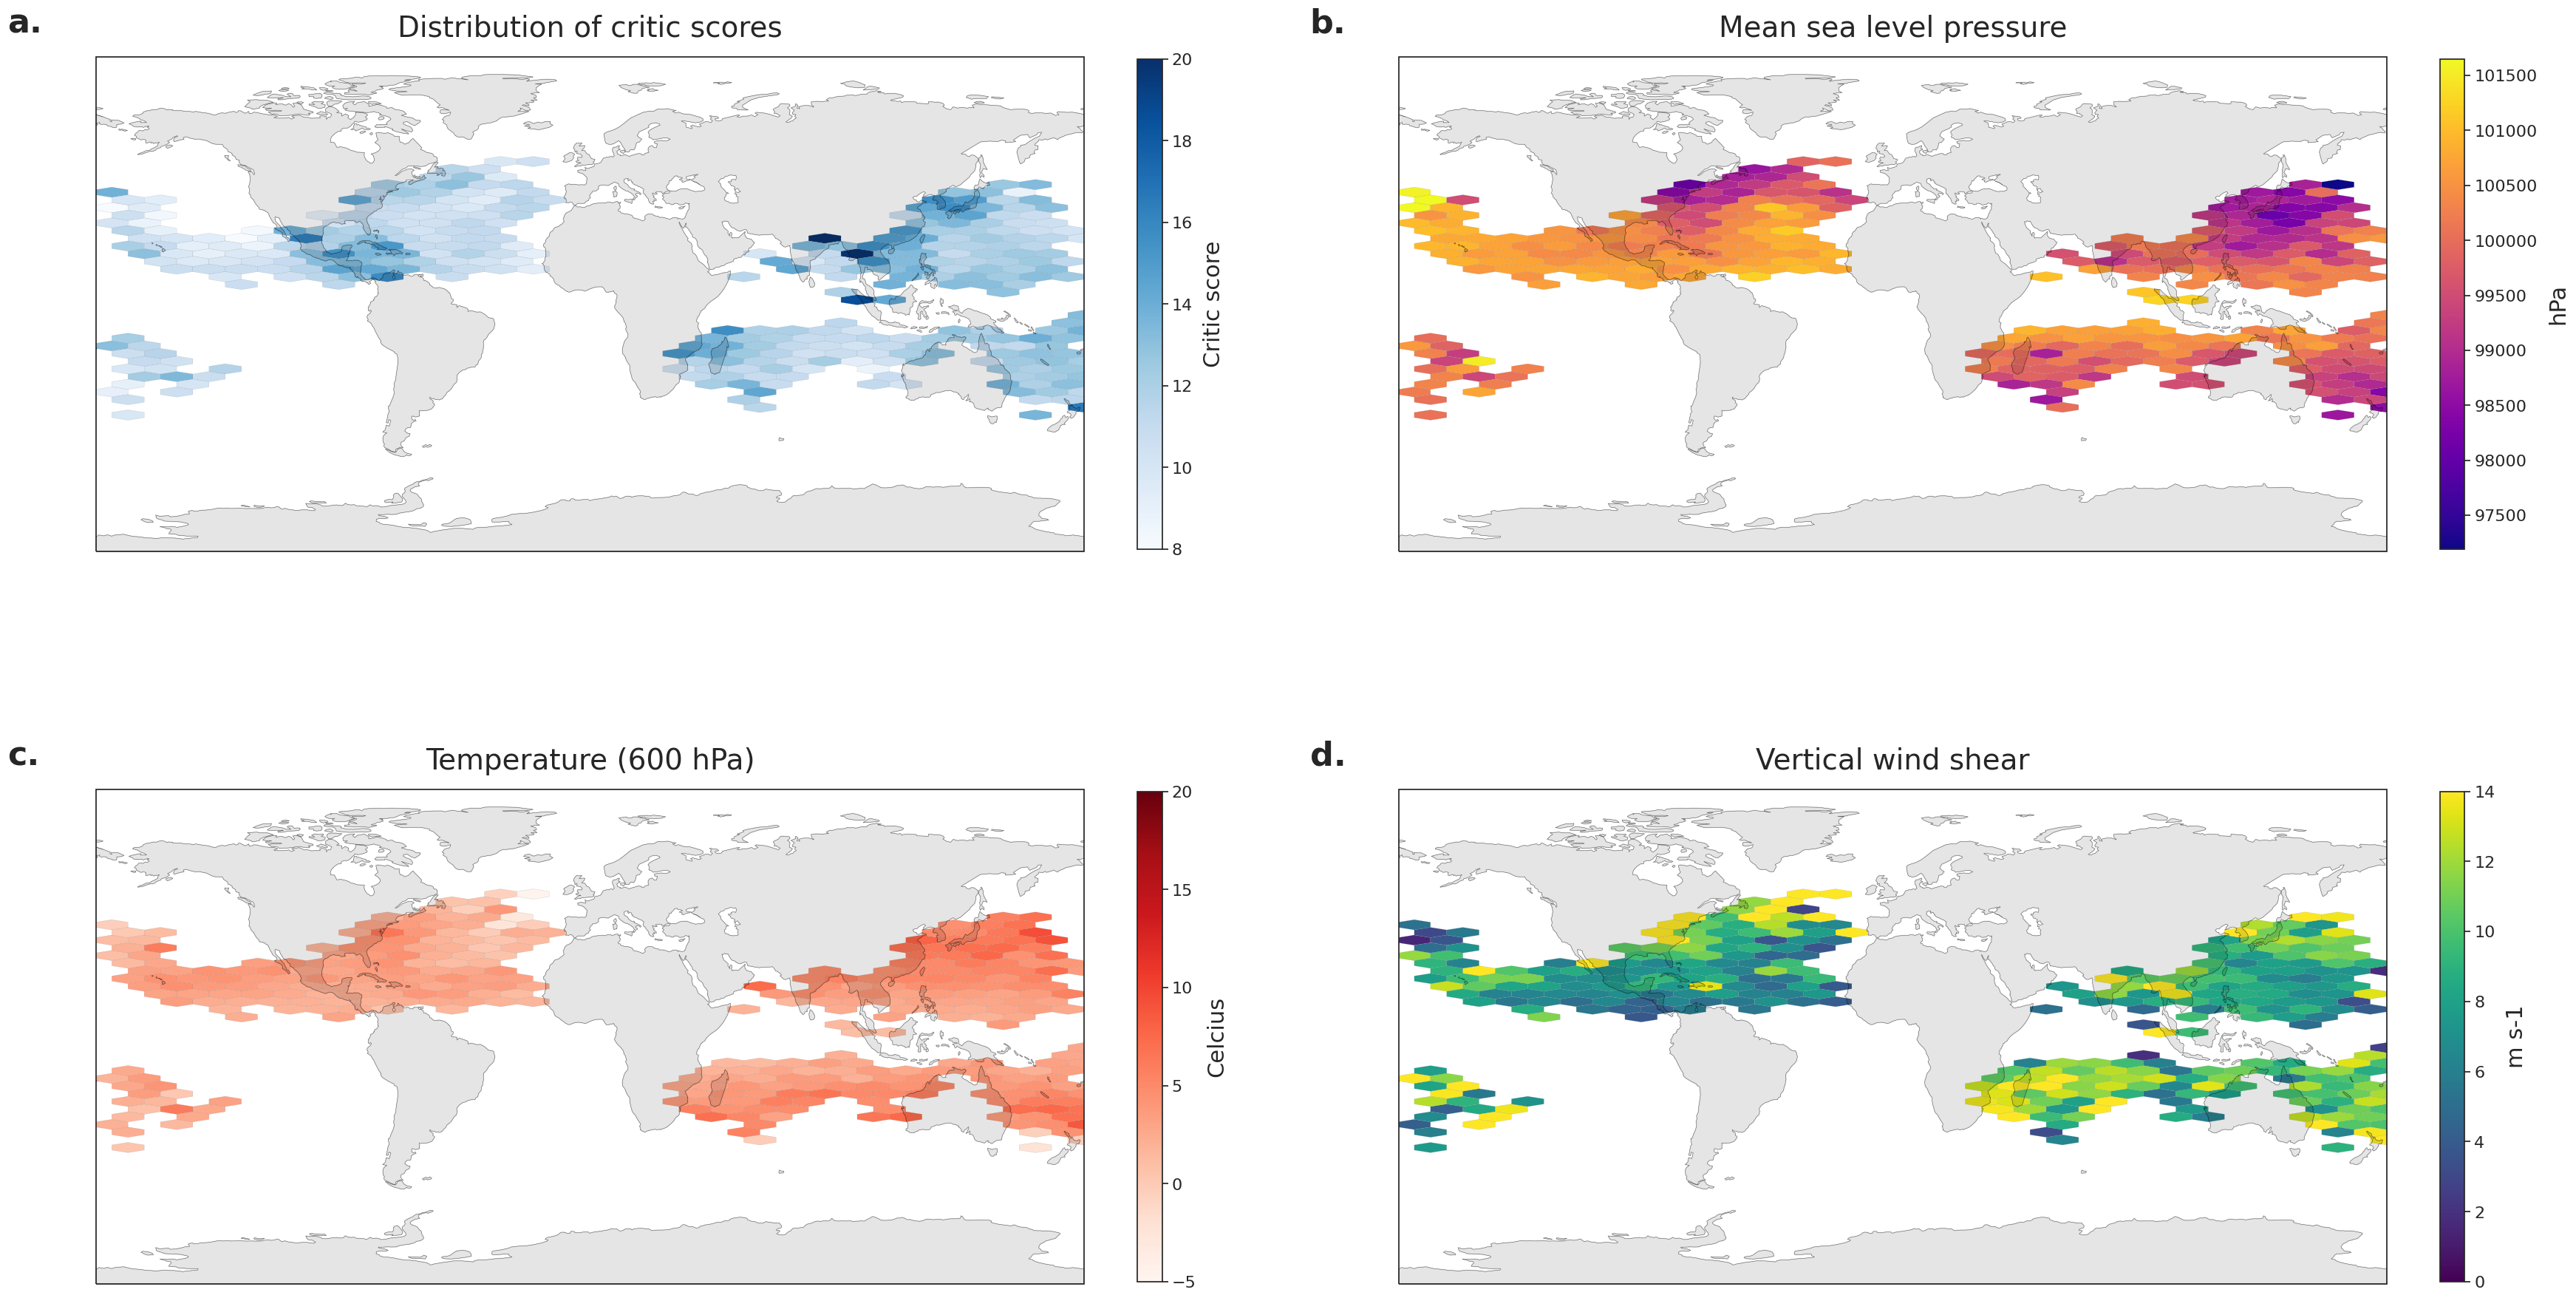

In [26]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=-2
vmax=2


fig, axes = plt.subplots(2,4,figsize=(35, 20),subplot_kw={'projection': ccrs.PlateCarree()},gridspec_kw={'width_ratios': [1, 0.001,1,0.001]})

# first panel
x = inputs_more[:,5]
y = inputs_more[:,4]
z = disc_pred[:,0,0]
print(np.min(z),np.max(z))
m = axes[0,0].hexbin(x,y, C=z, gridsize=30, cmap='Blues', mincnt=1, edgecolor='gray',vmin=8,vmax=20, reduce_C_function=np.mean,linewidth=0.1, transform=ccrs.PlateCarree())
# m = axes[0].hexbin(x,y, C=z, gridsize=30, cmap='Blues', mincnt=1, edgecolor='gray',vmin=2,vmax=22, reduce_C_function=np.max,linewidth=0.1, transform=ccrs.PlateCarree())
axes[0,0].add_feature(cfeature.COASTLINE,linewidth=0.2)
axes[0,0].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)
axes[0,0].tick_params(axis='x', labelsize=20)
axes[0,0].tick_params(axis='y', labelsize=20)
axes[0,0].set_title('Distribution of critic scores',fontsize=28,pad=20)
axes[0,1].set_visible(False)
# plt.colorbar(m,ax=axes[1],fraction = 0.25,pad=-0.5,label = 'Critic score')
cb1 = plt.colorbar(m,ax=axes[0,0],fraction = 0.023,pad=0.05,label = 'Critic score')
cb1.set_label(label = 'Critic score',size=22,labelpad=10)
cb1.ax.tick_params(labelsize=16) 

# second panel
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
vmin=-2
vmax=2
width_ratios = [1,0.1]

x = inputs_more[:,5]
y = inputs_more[:,4]
z = inputs_more[:,0]
m2 = axes[0,2].hexbin(x,y, C=z, gridsize=30, cmap='plasma', mincnt=1, edgecolor='gray', reduce_C_function=np.mean,linewidth=0.1, transform=ccrs.PlateCarree())
axes[0,2].add_feature(cfeature.COASTLINE,linewidth=0.2)
axes[0,2].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)

axes[0,2].tick_params(axis='x', labelsize=20)
axes[0,2].tick_params(axis='y', labelsize=20)
axes[0,2].set_title('Mean sea level pressure',fontsize=28,pad=20)
axes[0,3].set_visible(False)

cb2 = plt.colorbar(m2,ax=axes[0,2],fraction = 0.023,pad=0.05,label='hPa')
cb2.set_label(label='hPa',size=22,labelpad=10)
cb2.ax.tick_params(labelsize=16) 

# third panel
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
vmin=-2
vmax=2
width_ratios = [1,0.1]

x = inputs_more[:,5]
y = inputs_more[:,4]
z = inputs_more[:,6] - 273.15
m2 = axes[1,0].hexbin(x,y, C=z, gridsize=30, cmap='Reds', vmin=-5,vmax=20,mincnt=1, edgecolor='gray', reduce_C_function=np.mean,linewidth=0.1, transform=ccrs.PlateCarree())
axes[1,0].add_feature(cfeature.COASTLINE,linewidth=0.2)
axes[1,0].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)

axes[1,0].tick_params(axis='x', labelsize=20)
axes[1,0].tick_params(axis='y', labelsize=20)
axes[1,0].set_title('Temperature (600 hPa)',fontsize=28,pad=20)
axes[1,1].set_visible(False)

cb4 = plt.colorbar(m2,ax=axes[1,0],fraction = 0.023,pad=0.05,label='Celcius')
cb4.set_label(label='Celcius',size=22,labelpad=10)
cb4.ax.tick_params(labelsize=16) 

# fourth panel
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
vmin=-2
vmax=2
width_ratios = [1,0.1]

x = inputs_more[:,5]
y = inputs_more[:,4]
z = inputs_more[:,3]
m2 = axes[1,2].hexbin(x,y, C=z, gridsize=30, cmap='viridis', vmin=0,vmax=14,mincnt=1, edgecolor='gray', reduce_C_function=np.mean,linewidth=0.1, transform=ccrs.PlateCarree())
axes[1,2].add_feature(cfeature.COASTLINE,linewidth=0.2)
axes[1,2].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)

axes[1,2].tick_params(axis='x', labelsize=20)
axes[1,2].tick_params(axis='y', labelsize=20)
axes[1,2].set_title('Vertical wind shear',fontsize=28,pad=20)
axes[1,3].set_visible(False)

cb3 = plt.colorbar(m2,ax=axes[1,2],fraction = 0.023,pad=0.05,label='hPa')
cb3.set_label(label='m s-1',size=22,labelpad=10)
cb3.ax.tick_params(labelsize=16) 


# plt.savefig('figure_9d_mslp_distribution_4.png')
axes[0,0].set_global()
axes[0,2].set_global()
axes[1,0].set_global()
axes[1,2].set_global()

# axes[0].outline_patch.se t_linewidth(0.1)
# axes[1].patch.set_linewidth(0.1)

axes[0,0].text(-0.09, 1.05, 'a.', transform=axes[0,0].transAxes, size=32, weight='bold')
axes[0,2].text(-0.09, 1.05, 'b.', transform=axes[0,2].transAxes, size=32, weight='bold')
axes[1,0].text(-0.09, 1.05, 'c.', transform=axes[1,0].transAxes, size=32, weight='bold')
axes[1,2].text(-0.09, 1.05, 'd.', transform=axes[1,2].transAxes, size=32, weight='bold')
# 

plt.tight_layout()

plt.savefig('figure_9c_storm_distribution_5.png',bbox_inches='tight')

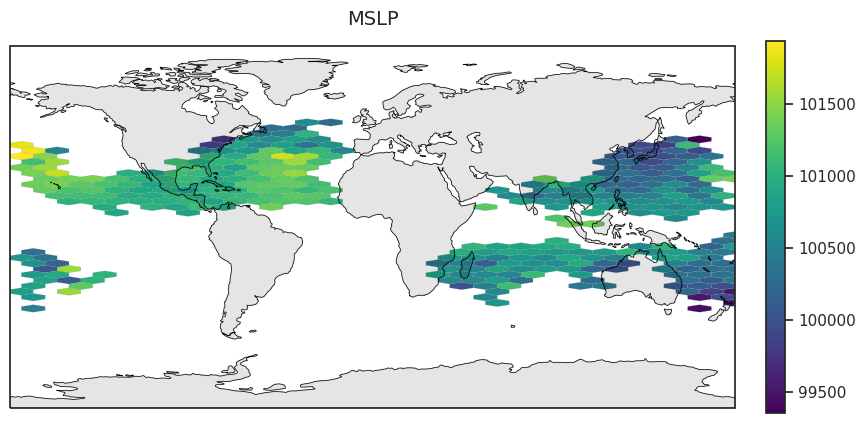

In [27]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=-2
vmax=2
width_ratios = [1,0.1]
fig, ax = plt.subplots(figsize=(10, 20),subplot_kw={'projection': ccrs.PlateCarree()})
# ax[1].set_axis_off()
# ax.contourf(inputs[:,5],inputs[:,4],inputs[:,0],levels=range(98000,102000,500000), transform=ccrs.PlateCarree(),cmap='Oranges')
# im = ax.pcolormesh(inputs[:,5],inputs[:,4],inputs[:,0], cmap='viridis', transform=ccrs.PlateCarree())
x = inputs[:,5]
y = inputs[:,4]
z = inputs[:,0]
m = ax.hexbin(x,y, C=z, gridsize=30, cmap='viridis', mincnt=1, edgecolor='gray', reduce_C_function=np.mean,linewidth=0.1, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
# 			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlabel_style = {'size': 14}
# gl.ylabel_style = {'size': 14}

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)


ax.set_title('MSLP',fontsize=14,pad=15)
ax.set_global()
# cbar_ax = fig.add_axes([1, 0.031, 0.03, 0.936])
# levels=[0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]

cb = plt.colorbar(m,fraction=0.024, pad=0.04)

plt.savefig('figure_9d_mslp_distribution_4.png')

In [28]:
print(gen_pred.shape)
print(real.shape)

(15930, 100, 100, 20)
(15930, 100, 100, 1)


In [29]:
y_pred = gen_pred[0:16,:,:,0:1]
y_true = real[0:16,:,:,:]

In [30]:
print(y_pred.shape)
print(y_true.shape)

(16, 100, 100, 1)
(16, 100, 100, 1)


In [31]:
wloss = np.mean(y_true * y_pred, axis=-1)

In [32]:
print(wloss.shape)

(16, 100, 100)


In [33]:
y_max = np.max(y_true,axis=-1) + 0.1 # gamma 
image_relevance_weighting = y_true[:,:,:,0] / y_max # Wsod / gamma to get values bwteen 0 and 1
image_relevance_weighting = np.power(y_true[:,:,:,0],2) # because we are normalising by the max for demonstration then this is actually not giving higher values
image_relevance_weighting = y_true[:,:,:,0]
# weight_avg = K.ones((y_true.shape)) # Wavg is a matrix of ones because we don't want 0 weight on everything
weight_avg = np.ones_like(y_true[:,:,:,0])
weight_avg_2 = np.mean(y_true[:,:,:,0]) # this is to remove low distance bias over drizzle and no rain - so that even images will small rain are seen as the same as other images
weight = weight_avg + image_relevance_weighting
# weight = weight[:,:,:,0]
# sigma = np.sum(weight)
wloss = np.mean(y_true * y_pred, axis=-1)
# wloss_max = np.max(y_true * y_pred, axis=-1)
wwloss = wloss * weight + weight_avg_2
wloss_norm = wloss[0,:,:] * 1/np.max(wloss[0,:,:])
wwloss_norm = wwloss[0,:,:] * 1/np.max(wwloss[0,:,:])

wloss = wloss[0,:,:]
wwloss = wwloss[0,:,:]



In [34]:
print(image_relevance_weighting.shape)
print(weight_avg.shape)
print(weight.shape)
print(y_max[0,:,:])
print(np.max(weight[0,:,:]))
print(np.max(wloss))
print(np.max(wwloss))

print(np.mean(wloss))
print(np.mean(wwloss))

print(np.std(wloss_norm))
print(np.std(wwloss_norm))


(16, 100, 100)
(16, 100, 100)
(16, 100, 100)
[[0.1        0.1        0.1        ... 0.1625     0.1        0.1       ]
 [0.1        0.1        0.1        ... 0.1625     0.1        0.1       ]
 [0.1        0.1        0.1        ... 0.1625     0.1        0.1       ]
 ...
 [0.66250001 0.66250001 0.66250001 ... 0.1625     0.1        0.1       ]
 [0.85000004 0.7875     0.7875     ... 0.1        0.1        0.1       ]
 [0.85000004 0.7875     0.7875     ... 0.1        0.1        0.1       ]]
22.125002208243583
244.9179492531132
4870.383995888031
4.6645253407027525
37.61204349458697
0.06186223648789901
0.0473922009963235


In [35]:
sns.set_style("white")
height_ratios = [1,0.1]
n = 2
m = 5
fig, axes = plt.subplots(n, m, figsize=(2*m + 0.1, 2*n), sharey=True,gridspec_kw={'height_ratios': height_ratios})


pal = sns.cubehelix_palette(10, rot=-.25, light=.7,as_cmap=True)

for i in range(m):
	for j in range(n):
		if j == 1:
			axes[j,i].set_axis_off()
			continue
		axes[j,i].set(xticklabels=[])
		axes[j,i].set(yticklabels=[])
		axes[j,i].spines['right'].set_color('#A9A9A9')  # Right spine color
		axes[j,i].spines['right'].set_linewidth(1) 
		axes[j,i].spines['left'].set_color('#A9A9A9')  # left spine color
		axes[j,i].spines['left'].set_linewidth(1)
		axes[j,i].spines['top'].set_color('#A9A9A9')  # top spine color
		axes[j,i].spines['top'].set_linewidth(1) 
		axes[j,i].spines['bottom'].set_color('#A9A9A9')  # bottom spine color
		axes[j,i].spines['bottom'].set_linewidth(1) 

# define cmap
precip_cmap,precip_norm = make_cmap()
norm = precip_norm

axes[0,0].text(-0.1, 1.05, 'a.', transform=axes[0,0].transAxes, size=16, weight='bold')
# axes[2,0].text(-0.1, 1.05, 'b.', transform=axes[2,0].transAxes, size=16, weight='bold')

# Define a colormap (you can choose a different one if you prefer)
cmap = plt.get_cmap('BuPu')

# Create a normalization instance for the colormap
norm2 = mcolors.Normalize(vmin=0, vmax=1)
norm2 = mcolors.PowerNorm(vmin=0, vmax=np.max(wloss), gamma = 1/6)
norm3 = mcolors.PowerNorm(vmin=0, vmax=np.max(wwloss), gamma = 1/6)


im = axes[0,0].imshow(y_true[0,:,:], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,0].invert_yaxis()
axes[0,1].imshow(y_pred[0,:,:], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
axes[0,1].invert_yaxis()
axes[0,2].imshow(wloss, interpolation='nearest', norm=norm2,extent=None,cmap=cmap)
axes[0,2].invert_yaxis()
axes[0,3].imshow(weight[0,:,:], interpolation='nearest', norm=mcolors.Normalize(vmin=1, vmax=2),extent=None,cmap='RdPu')
axes[0,3].invert_yaxis()
axes[0,4].imshow(wwloss, interpolation='nearest',norm=norm3,extent=None,cmap=cmap)
axes[0,4].invert_yaxis()
# axes[0,5].imshow(pred_10[storms[5],:,:,0], interpolation='nearest', norm=norm,extent=None,cmap=precip_cmap)
# axes[0,5].invert_yaxis()




fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
# cbar_ax = fig.add_axes([1, 0.031, 0.03, 0.936])
cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
# cbar_ax = fig.add_axes([0, -0.1, 1, 0.02])
levels=[0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.01,ticks=levels)
cb.ax.tick_params(labelsize=12)
cb.set_label('mm / 3hr', fontsize=16)
fig.tight_layout()

plt.savefig('figure_9f_wloss_3.png',bbox_inches='tight',dpi=600)
plt.clf()

/tmp/ipykernel_253095/3457720115.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<Figure size 1010x400 with 0 Axes>

In [36]:
sorting = np.argsort(np.ravel(y_true[0,:,:]))
rain_sort = np.ravel(y_true)[sorting]
weightt = weight[0,:,:]
weight_sort = np.ravel(weightt)[sorting]
wloss_sort = np.ravel(wloss)[sorting]
wwloss_sort = np.ravel(wwloss)[sorting]

In [37]:
print(sorting)

[  35 5700 5701 ... 5090 5091 5092]


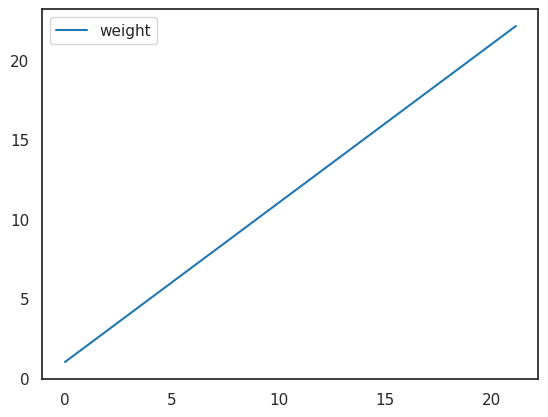

In [38]:
plt.plot(rain_sort,weight_sort)
# plt.plot(rain_sort,wloss_sort)
# plt.plot(rain_sort,wwloss_sort)
plt.legend(['weight','wloss','wwloss'])
# plt.yscale('log')
plt.show()

In [39]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

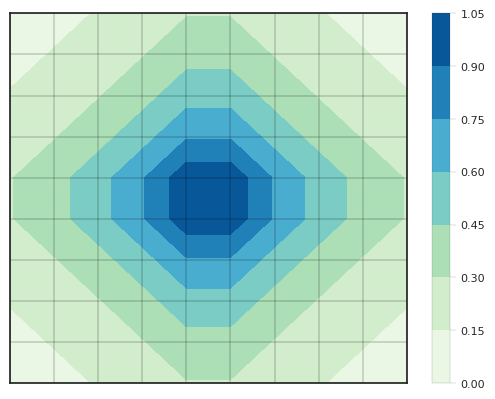

In [40]:
sns.set_style("white")
fig, ax = plt.subplots()

center_row, center_col = 10 // 2 , 10 // 2 
row_grid, col_grid = np.ogrid[:10, :10]

centre_weights = np.exp(-((row_grid - center_row) ** 2 + (col_grid - center_col) ** 2) / (2.0 * 3**2))  # 3 is the standard deviation
centre_weights_2 = np.exp(-((row_grid - center_row) ** 2 + (col_grid - center_col) ** 2) / (2.0 * 5**2))

distance_from_center = np.maximum(np.abs(row_grid - center_row), np.abs(col_grid - center_col))
centre_weights_3 = np.exp(-distance_from_center / (2.0 * 5**2))

centre_weights_4 = np.exp(-((np.minimum(np.abs(row_grid - center_row), np.abs(row_grid - center_row + 1)) +
                             np.minimum(np.abs(col_grid - center_col), np.abs(col_grid - center_col + 1))) / 2.0) / (2.0 * 5**2))

centre_weights_5 = np.exp(-((np.minimum(np.abs(row_grid - center_row), np.abs(row_grid - center_row + 1)) +
                             np.minimum(np.abs(col_grid - center_col), np.abs(col_grid - center_col + 1))) / 2.0) / (2.0 * 0.9**2))


m = ax.contourf(centre_weights_5,cmap='GnBu',zorder=-1.0)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.grid(visible=True,which='major', color='black', linestyle='-',linewidth=0.2)
# plt.grid(which='minor', axis='y',color='black')
matplotlib.rcParams['axes.linewidth'] = 0.1
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid(True)
cbar = plt.colorbar(m)
cbar.ax.tick_params(labelsize=8,length=4, width=0.1, which="major")

plt.savefig('figure_9_patchloss.png',bbox_inches='tight')